In [1]:
import os
from shapely.geometry import Point, Polygon
from shapely.vectorized import contains
from tifffile import imread
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
import multiprocessing as mp

sns.set(color_codes=True, style="white")

# Setup

In [2]:
# === SPATIAL ANALYSIS PARAMETERS ===
# Define the spatial scale and binning for pair correlation analysis

nm_per_pxl = 23.4  # Nanometers per pixel (microscope calibration)
r_max_nm = 1120  # Maximum distance to analyze (nm)
ringwidth_nm = 100  # Width of each distance bin (nm)
dr_slidingrings_nm = 20  # Step size between overlapping bins (nm)

# === DISTANCE BIN SETUP ===
# Create overlapping distance bins (sliding window approach)
# This gives high spatial resolution by overlapping bins
bins = np.arange(0, r_max_nm - ringwidth_nm, dr_slidingrings_nm)
bin_starts = np.arange(0, r_max_nm - ringwidth_nm, dr_slidingrings_nm)
bin_ends = bin_starts + ringwidth_nm

# === PRECOMPUTE RING AREAS ===
# Calculate ring areas for normalization (avoids repeated calculation)
ring_areas_nm2 = np.pi * (bin_ends**2 - bin_starts**2)  # Ring areas in nm²
ring_areas_pxl2 = ring_areas_nm2 / (nm_per_pxl**2)  # Ring areas in pixel²

# === FILE PATH SETUP ===
folder = "/Volumes/guttman/Guoming_Gao-Resnick/Data_BIF/DEFAULT_USER/20250424_ONIdemo_Guoming/Guoming_data/dSTORM/dSTORM_tif/Malat1"
os.chdir(folder)

# Data files (localization coordinates)
ch1_file = "dSTORM1_TX_nodiff_Malat_AF647_AF488-3-cropped-left-driftcorrected.csv"
ch2_file = "dSTORM1_TX_nodiff_Malat_AF647_AF488-3-cropped-right-driftcorrected.csv"

# === LOAD DATA ONCE (MEMORY EFFICIENT) ===
# Load both data files once and reuse for all blobs
# This avoids repeated file I/O operations

print("Loading data files...")
# Channel 1: Interest points (10% random sample)
df_interest = pd.read_csv(
    ch1_file,
    skiprows=lambda i: i > 0 and random.random() > 0.1,  # Keep 10% of data
)
df_interest["x"] = df_interest["x [nm]"] / nm_per_pxl  # Convert to pixels
df_interest["y"] = df_interest["y [nm]"] / nm_per_pxl

# Channel 2: Reference points (100% of data)
df_ref = pd.read_csv(
    ch2_file,
    skiprows=lambda i: i > 0 and random.random() > 1,  # Keep all data
)
df_ref["x"] = df_ref["x [nm]"] / nm_per_pxl  # Convert to pixels
df_ref["y"] = df_ref["y [nm]"] / nm_per_pxl

print(f"Loaded {len(df_interest)} interest points and {len(df_ref)} reference points")

# === PARALLEL PROCESSING SETUP ===
# Determine optimal number of CPU cores to use
# Leave one core free for system operations
# blob_roi_files = [
#     f
#     for f in os.listdir(".")
#     if (f.startswith(ch1_file.split("-cropped")[0]) & ("blob" in f))
# ]
# n_processes = min(len(blob_roi_files), mp.cpu_count() - 1)
# print(f"Using {n_processes} processes for {len(blob_roi_files)} blobs")

Loading data files...
Loaded 26479 interest points and 542954 reference points


# Section 1: Segmentation

Found 61 total contours
61 valid polygons
24 after area and intensity filtering


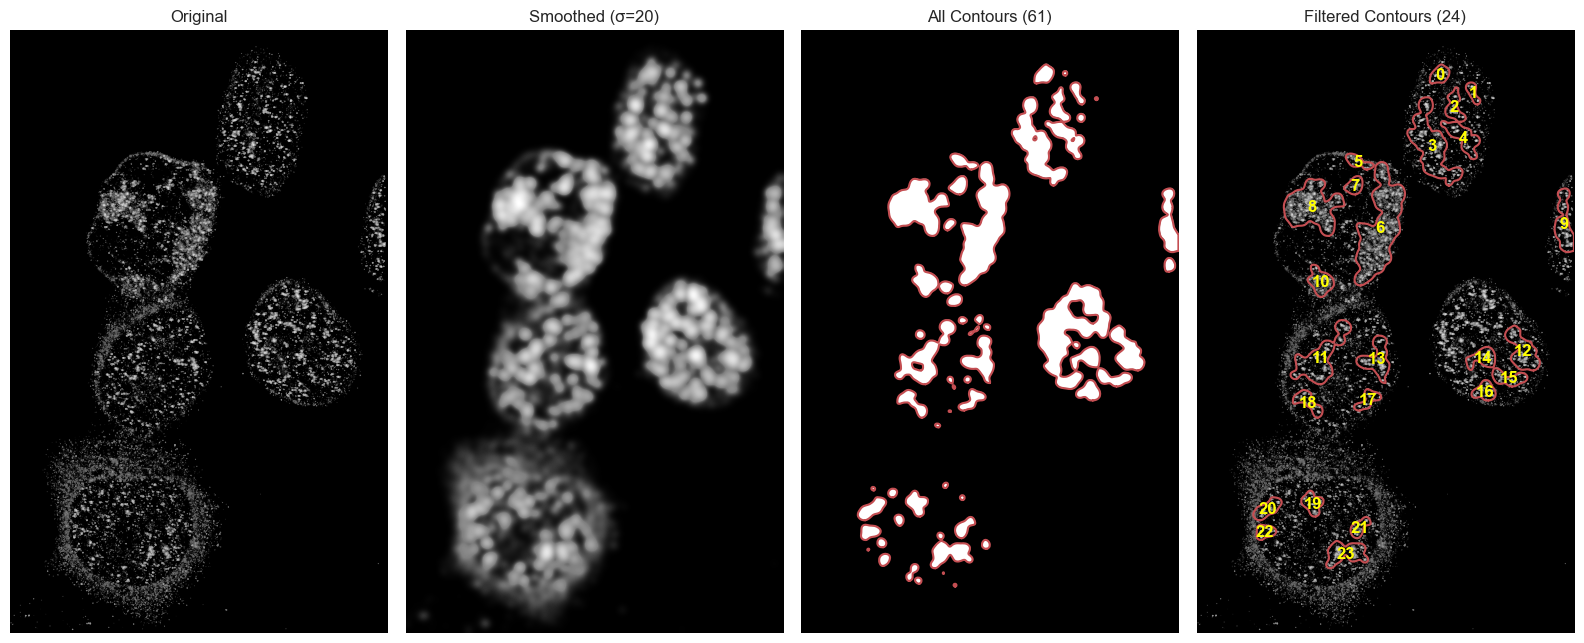

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from tifffile import imread
from skimage.measure import find_contours
from shapely.geometry import Polygon
from matplotlib.patches import Polygon as MplPolygon
from skimage.draw import polygon

# =============================================================================
# PARAMETERS TO TUNE
# =============================================================================
fname_STORM = (
    "dSTORM1_TX_nodiff_Malat_AF647_AF488-3-cropped-composite-driftcorrected.tif"
)

# Gaussian smoothing parameters
sigma = 20
mode = "reflect"

# Thresholding parameters
threshold = 0.11  # Adjust this value (0.0 to 1.0 for normalized data)

# Area filtering parameters
area_threshold_min = 5e3
area_threshold_max = 1e5
# =============================================================================

# Load and process your image
img_STORM = imread(fname_STORM)
img_STORM_ave = np.mean(img_STORM, axis=0)

# Apply Gaussian smoothing
img_smoothed = gaussian_filter(img_STORM_ave, sigma=sigma, mode=mode)

# Create thresholded segmentation
# Normalize the smoothed image to 0-1 range for consistent thresholding
img_normalized = (img_smoothed - img_smoothed.min()) / (
    img_smoothed.max() - img_smoothed.min()
)
img_thresholded = img_normalized > threshold

# Extract contours
contours = find_contours(img_thresholded, 0.5)

# Convert contours to shapely polygons and filter by area AND average intensity
all_polygons = []
filtered_polygons = []

for contour in contours:
    if len(contour) >= 3:  # Need at least 3 points for a polygon
        try:
            polygon_shapely = Polygon(
                contour[:, [1, 0]]
            )  # Switch to x,y format for shapely
            if polygon_shapely.is_valid:
                all_polygons.append(polygon_shapely)

                # Check if area is within bounds
                if area_threshold_min < polygon_shapely.area < area_threshold_max:
                    # Calculate average intensity within this contour using original (row, col) coordinates
                    rr, cc = polygon(contour[:, 0], contour[:, 1], img_normalized.shape)
                    if len(rr) > 0:  # Make sure we have interior pixels
                        avg_intensity = np.mean(img_normalized[rr, cc])

                        # Only keep if average intensity > threshold (filters out valleys)
                        if avg_intensity > threshold:
                            filtered_polygons.append(polygon_shapely)
        except Exception as e:
            continue

print(f"Found {len(contours)} total contours")
print(f"{len(all_polygons)} valid polygons")
print(f"{len(filtered_polygons)} after area and intensity filtering")

# Display all images with contours
fig, axes = plt.subplots(1, 4, figsize=(16, 7))

axes[0].imshow(img_STORM_ave, norm="symlog", cmap="gray")
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(img_smoothed, norm="symlog", cmap="gray")
axes[1].set_title(f"Smoothed (σ={sigma})")
axes[1].axis("off")

axes[2].imshow(img_thresholded, cmap="gray")
axes[2].set_title(f"All Contours ({len(all_polygons)})")
# Show all contours on the thresholded image
for polygon_shapely in all_polygons:
    x, y = polygon_shapely.exterior.xy
    axes[2].plot(x, y, "r-", linewidth=1.5)
axes[2].axis("off")

# Show original with filtered contours overlaid and indexed
axes[3].imshow(img_STORM_ave, norm="symlog", cmap="gray")
axes[3].set_title(f"Filtered Contours ({len(filtered_polygons)})")
for idx, polygon_shapely in enumerate(filtered_polygons):
    # Draw contour
    x, y = polygon_shapely.exterior.xy
    axes[3].plot(x, y, "r-", linewidth=1.5)

    # Add index label at polygon centroid
    centroid = polygon_shapely.centroid
    axes[3].text(
        centroid.x,
        centroid.y,
        str(idx),
        color="yellow",
        fontsize=12,
        fontweight="bold",
        ha="center",
        va="center",
    )
axes[3].axis("off")

plt.tight_layout()
plt.savefig(
    fname_STORM.split("-cropped")[0] + "-segmented_blobs.png",
    format="png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [4]:
n_processes = min(len(filtered_polygons), mp.cpu_count() - 1)

# Section 2: PCF

### Functions

In [5]:
def corr_within_blob_polygon_truly_vectorized(df, blob_polygon):
    """
    Truly vectorized polygon filtering using shapely's vectorized operations.

    Performance optimization strategy:
    1. Quick bounds check (rectangular filter) - O(1) numpy operation
    2. Detailed polygon check only on candidates - reduces expensive geometry ops
    3. Use shapely's vectorized contains() - C-optimized batch processing

    Args:
        df: DataFrame with 'x' and 'y' columns
        blob_polygon: Shapely Polygon object

    Returns:
        tuple: (x_array, y_array) of points within polygon
    """
    # Step 1: Fast rectangular bounds check (vectorized numpy operations)
    # This eliminates most points without expensive geometric calculations
    minx, miny, maxx, maxy = blob_polygon.bounds

    mask_bounds = (
        (df["x"] >= minx) & (df["x"] <= maxx) & (df["y"] >= miny) & (df["y"] <= maxy)
    )

    # Step 2: Only check detailed polygon containment for points within bounds
    # This reduces the number of expensive Point().within() operations
    df_candidates = df[mask_bounds]

    if len(df_candidates) == 0:
        return np.array([]), np.array([])

    # Step 3: Use shapely's vectorized contains function (C-optimized)
    # This is ~5-10x faster than creating Point objects in a loop
    mask_within = contains(blob_polygon, df_candidates["x"], df_candidates["y"])

    final_points = df_candidates[mask_within]
    return final_points["x"].values, final_points["y"].values


def quick_PCF_vectorized(
    x_ref,
    y_ref,
    x_interest,
    y_interest,
    N_ref,
    bin_starts,
    bin_ends,
    nm_per_pxl,
    ring_areas_pxl2,
    ring_areas_nm2,
    blob_polygon,
    rho_interest_per_nm2,
):
    """
    Highly optimized PCF calculation with vectorization and efficient memory usage.

    Key optimizations:
    1. Vectorized distance calculations - all distances computed at once
    2. Broadcasting for histogram binning - matrix operations instead of loops
    3. Efficient edge correction calculation
    4. Progress tracking for long computations

    Args:
        x_ref, y_ref: Reference point coordinates
        x_interest, y_interest: Interest point coordinates
        N_ref: Number of reference points
        bin_starts, bin_ends: Distance bin boundaries
        nm_per_pxl: Nanometers per pixel conversion
        ring_areas_*: Precomputed ring areas for normalization
        blob_polygon: blob boundary for edge correction
        rho_interest_per_nm2: Interest point density

    Returns:
        numpy.array: Pair correlation function values for each distance bin
    """

    def process_reference_point(i):
        """
        Process a single reference point with vectorized operations.

        This function calculates:
        1. Edge correction factors for this reference point
        2. Distances to all interest points (vectorized)
        3. Histogram binning (vectorized with broadcasting)
        """

        # === EDGE CORRECTION CALCULATION ===
        # Create annular rings around reference point for edge correction
        # Each ring represents a distance bin
        rings = [
            Point(x_ref[i], y_ref[i])
            .buffer(end)  # Create circle with radius = end
            .difference(
                Point(x_ref[i], y_ref[i]).buffer(start)
            )  # Subtract inner circle
            for start, end in zip(bin_starts / nm_per_pxl, bin_ends / nm_per_pxl)
        ]

        # Calculate how much of each ring intersects with blob boundary
        # This determines the "observable area" for edge correction
        intersect_areas = np.array(
            [
                blob_polygon.intersection(Polygon(ring), grid_size=0.1).area
                for ring in rings
            ]
        )

        # Edge correction factor = 1 / (fraction of ring area observable)
        # If only half the ring is in the blob, we need to multiply counts by 2
        edge_correction_factors = 1 / (intersect_areas / ring_areas_pxl2)

        # === VECTORIZED DISTANCE CALCULATION ===
        # OLD WAY (slow): Loop through each interest point, calculate distance one by one
        # NEW WAY (fast): Calculate ALL distances at once using numpy broadcasting

        # Vectorized calculation: compute distances to ALL interest points simultaneously
        # This replaces a loop of length N_interest with a single numpy operation
        distances = (
            np.sqrt((x_ref[i] - x_interest) ** 2 + (y_ref[i] - y_interest) ** 2)
            * nm_per_pxl
        )

        # === VECTORIZED HISTOGRAM BINNING ===
        # OLD WAY (slow): Loop through distances, check which bin each belongs to
        # NEW WAY (fast): Use numpy broadcasting to create a matrix comparison

        # Create boolean matrix: rows = bins, cols = distances
        # hist_matrix[bin_idx, distance_idx] = True if distance falls in that bin
        hist_matrix = (bin_starts[:, np.newaxis] <= distances) & (
            bin_ends[:, np.newaxis] >= distances
        )

        # Sum across distances to get count per bin
        hist_per_point = np.sum(hist_matrix, axis=1)

        # Apply edge correction to compensate for boundary effects
        return hist_per_point * edge_correction_factors

    # === MAIN PCF CALCULATION ===
    # Process each reference point with progress tracking
    hist_results = []
    for i in tqdm(range(len(x_ref)), desc="Calculating PCF", leave=False):
        hist_results.append(process_reference_point(i))

    # === NORMALIZATION ===
    # Convert raw counts to pair correlation function
    # PCF = (observed pairs) / (expected pairs for random distribution)
    norm_factors_cross = N_ref * ring_areas_nm2 * rho_interest_per_nm2

    # Sum histograms from all reference points and normalize
    PairCorr_cross = np.sum(hist_results, axis=0) / norm_factors_cross

    return PairCorr_cross


def create_blob_polygon(blob_roi_file, nm_per_pxl):
    """
    Create a Shapely Polygon from ROI coordinate file.

    Args:
        blob_roi_file: Path to tab-separated file with polygon coordinates (in micrometers)
        nm_per_pxl: Conversion factor from nanometers to pixels

    Returns:
        shapely.geometry.Polygon: blob boundary polygon in pixel coordinates
    """
    # Load coordinates (assumed to be in micrometers)
    blob_outline_coordinates = pd.read_csv(blob_roi_file, sep="\t", header=None)

    # Convert from micrometers to pixels: um * 1000 / nm_per_pxl
    coords_roi = [
        tuple(row * 1000 / nm_per_pxl) for _, row in blob_outline_coordinates.iterrows()
    ]

    blob_polygon = Polygon(coords_roi)
    return blob_polygon


def process_single_blob(args):
    """
    Process a single blob ROI - optimized for multiprocessing.

    This function is designed to be called in parallel for multiple blobs.
    All arguments are packed into a single tuple for multiprocessing compatibility.

    Processing steps:
    1. Create blob polygon from ROI file
    2. Filter points to those within blob boundary (vectorized)
    3. Calculate point densities
    4. Compute pair correlation function
    5. Return comprehensive results with metadata

    Args:
        args: Tuple containing all necessary parameters for processing

    Returns:
        dict: Results dictionary with PCF data and metadata, or error info
    """
    (
        # blob_roi_file,
        blob_idx,
        blob_polygon,
        df_ref,
        df_interest,
        nm_per_pxl,
        bin_starts,
        bin_ends,
        ring_areas_pxl2,
        ring_areas_nm2,
    ) = args

    try:
        # === blob BOUNDARY SETUP ===
        # blob_polygon = create_blob_polygon(blob_roi_file, nm_per_pxl)

        # === POINT FILTERING (VECTORIZED) ===
        # Filter points to only those within blob boundary using optimized vectorized method
        x_ref, y_ref = corr_within_blob_polygon_truly_vectorized(df_ref, blob_polygon)
        x_interest, y_interest = corr_within_blob_polygon_truly_vectorized(
            df_interest, blob_polygon
        )

        # === VALIDATION ===
        N_ref = x_ref.shape[0]
        N_interest = x_interest.shape[0]

        # Skip blobs with no points (would cause division by zero)
        if N_ref == 0 or N_interest == 0:
            return {
                # "blob_name": blob_roi_file,
                "error": f"No points found (N_ref={N_ref}, N_interest={N_interest})",
                "success": False,
            }

        # === DENSITY CALCULATIONS ===
        # Calculate point densities for normalization
        blob_polygon_area_nm2 = blob_polygon.area * (nm_per_pxl**2)
        rho_ref_per_nm2 = N_ref / blob_polygon_area_nm2
        rho_interest_per_nm2 = N_interest / blob_polygon_area_nm2

        # === PCF CALCULATION ===
        # Main computation using vectorized PCF function
        pcf_cross = quick_PCF_vectorized(
            x_ref,
            y_ref,
            x_interest,
            y_interest,
            N_ref,
            bin_starts,
            bin_ends,
            nm_per_pxl,
            ring_areas_pxl2,
            ring_areas_nm2,
            blob_polygon,
            rho_interest_per_nm2,
        )

        # === RETURN COMPREHENSIVE RESULTS ===
        return {
            "blob_name": blob_idx,
            "pcf_cross": pcf_cross,  # Main result: PCF values
            "N_ref": N_ref,  # Reference point count
            "N_interest": N_interest,  # Interest point count
            "rho_ref_per_nm2": rho_ref_per_nm2,  # Reference point density
            "rho_interest_per_nm2": rho_interest_per_nm2,  # Interest point density
            "blob_area_nm2": blob_polygon_area_nm2,  # blob area for validation
            "success": True,
        }

    except Exception as e:
        # Return error information for debugging
        return {"blob_name": blob_idx, "error": str(e), "success": False}

### Main

In [6]:
# === PREPARE PARALLEL PROCESSING ARGUMENTS ===
# Package all arguments for each blob into tuples for multiprocessing
process_args = [
    (
        # blob_roi_file,
        blob_idx,
        blob_polygon,
        df_ref,
        df_interest,
        nm_per_pxl,
        bin_starts,
        bin_ends,
        ring_areas_pxl2,
        ring_areas_nm2,
    )
    # for blob_roi_file in blob_roi_files
    for blob_idx, blob_polygon in enumerate(filtered_polygons)
]

# === PARALLEL PROCESSING EXECUTION ===
# Use ThreadPoolExecutor instead of ProcessPoolExecutor for Jupyter compatibility
from concurrent.futures import ThreadPoolExecutor

all_results = []  # Successful results
failed_results = []  # Failed processing attempts

print("Processing blobs in parallel...")
with ThreadPoolExecutor(max_workers=n_processes) as executor:  # Changed this line
    # === SUBMIT ALL JOBS ===
    future_to_blob = {
        executor.submit(process_single_blob, args): args[0] for args in process_args
    }

    # === COLLECT RESULTS WITH PROGRESS TRACKING ===
    for future in tqdm(
        as_completed(future_to_blob), total=len(future_to_blob), desc="Processing blobs"
    ):
        blob_name = future_to_blob[future]

        try:
            result = future.result()

            if result["success"]:
                all_results.append(result)
                print(
                    f"✓ {result['blob_name']}: N_ref={result['N_ref']}, "
                    f"N_interest={result['N_interest']}"
                )
            else:
                failed_results.append(result)
                print(f"✗ {result['blob_name']}: {result['error']}")

        except Exception as e:
            failed_results.append(
                {"blob_name": blob_name, "error": str(e), "success": False}
            )
            print(f"✗ {blob_name}: {e}")


# === FINAL RESULTS SUMMARY ===
# print(
#     f"\n🎉 Successfully processed {len(all_results)} blobs out of {len(blob_roi_files)} total"
# )
print(
    f"\n🎉 Successfully processed {len(all_results)} blobs out of {len(filtered_polygons)} total"
)
print(f"⚠️  Failed: {len(failed_results)} blobs")

# === DETAILED RESULTS OUTPUT ===
if all_results:
    print("\n📊 Detailed Results Summary:")
    print("-" * 80)
    print(f"{'blob Name':<40} {'N_ref':<8} {'N_interest':<12} {'Area (nm²)':<15}")
    print("-" * 80)

    for result in all_results:
        print(
            f"{result['blob_name']:<40} {result['N_ref']:<8} "
            f"{result['N_interest']:<12} {result['blob_area_nm2']:<15.0f}"
        )

    print("\n💡 Access individual PCF results with: all_results[0]['pcf_cross']")
    print("💡 Distance bins available as: bin_starts and bin_ends")

Processing blobs in parallel...


Processing blobs:   0%|          | 0/24 [00:00<?, ?it/s]

Calculating PCF:   0%|          | 0/5418 [00:00<?, ?it/s]

Calculating PCF:   0%|          | 0/3858 [00:00<?, ?it/s]

Calculating PCF:   0%|          | 0/5140 [00:00<?, ?it/s]

Calculating PCF:   0%|          | 0/2914 [00:00<?, ?it/s]

Calculating PCF:   0%|          | 0/7316 [00:00<?, ?it/s]

Calculating PCF:   0%|          | 0/48199 [00:00<?, ?it/s]

Calculating PCF:   0%|          | 0/8739 [00:00<?, ?it/s]

Calculating PCF:   0%|          | 0/33749 [00:00<?, ?it/s]

Calculating PCF:   0%|          | 0/62119 [00:00<?, ?it/s]

✓ 1: N_ref=2914, N_interest=138


Calculating PCF:   0%|          | 0/15316 [00:00<?, ?it/s]

✓ 0: N_ref=3858, N_interest=254


Calculating PCF:   0%|          | 0/8060 [00:00<?, ?it/s]

✓ 5: N_ref=5140, N_interest=122


Calculating PCF:   0%|          | 0/23013 [00:00<?, ?it/s]

✓ 7: N_ref=5418, N_interest=217


Calculating PCF:   0%|          | 0/13836 [00:00<?, ?it/s]

✓ 2: N_ref=7316, N_interest=133


Calculating PCF:   0%|          | 0/13510 [00:00<?, ?it/s]

✓ 4: N_ref=8739, N_interest=665


Calculating PCF:   0%|          | 0/9794 [00:00<?, ?it/s]

✓ 10: N_ref=8060, N_interest=375


Calculating PCF:   0%|          | 0/6423 [00:00<?, ?it/s]

✓ 15: N_ref=6423, N_interest=179


Calculating PCF:   0%|          | 0/6126 [00:00<?, ?it/s]

✓ 9: N_ref=15316, N_interest=551


Calculating PCF:   0%|          | 0/4117 [00:00<?, ?it/s]

✓ 14: N_ref=9794, N_interest=405


Calculating PCF:   0%|          | 0/5281 [00:00<?, ?it/s]

✓ 12: N_ref=13836, N_interest=719


Calculating PCF:   0%|          | 0/6080 [00:00<?, ?it/s]

✓ 13: N_ref=13510, N_interest=788


Calculating PCF:   0%|          | 0/5927 [00:00<?, ?it/s]

✓ 17: N_ref=4117, N_interest=195


Calculating PCF:   0%|          | 0/3435 [00:00<?, ?it/s]

✓ 18: N_ref=5281, N_interest=222


Calculating PCF:   0%|          | 0/3500 [00:00<?, ?it/s]

✓ 16: N_ref=6126, N_interest=203


Calculating PCF:   0%|          | 0/15394 [00:00<?, ?it/s]

✓ 19: N_ref=6080, N_interest=112
✓ 21: N_ref=3435, N_interest=149
✓ 20: N_ref=5927, N_interest=213
✓ 22: N_ref=3500, N_interest=121
✓ 11: N_ref=23013, N_interest=1065
✓ 3: N_ref=33749, N_interest=1669
✓ 23: N_ref=15394, N_interest=263
✓ 8: N_ref=48199, N_interest=2143
✓ 6: N_ref=62119, N_interest=2928

🎉 Successfully processed 24 blobs out of 24 total
⚠️  Failed: 0 blobs

📊 Detailed Results Summary:
--------------------------------------------------------------------------------
blob Name                                N_ref    N_interest   Area (nm²)     
--------------------------------------------------------------------------------
1                                        2914     138          2877702        
0                                        3858     254          4615657        
5                                        5140     122          4072477        
7                                        5418     217          4053860        
2                                       

### Normalization

In [7]:
def get_baseline_quality_assessment(baseline_cv):
    """
    Assess the quality of PCF normalization based on baseline coefficient of variation.
    """
    if baseline_cv < 0.05:  # < 5%
        return {
            "quality_category": "consistent_baseline",
            "quality_description": "Very consistent baseline - reliable normalization",
            "confidence": "high",
        }
    elif baseline_cv < 0.10:  # 5-10%
        return {
            "quality_category": "acceptable_noise_in_baseline",
            "quality_description": "Acceptable noise level - normalization valid",
            "confidence": "high",
        }
    elif baseline_cv < 0.20:  # 10-20%
        return {
            "quality_category": "some_variability_in_baseline",
            "quality_description": "Some variability present - check data quality",
            "confidence": "medium",
        }
    elif baseline_cv < 0.30:  # 20-30%
        return {
            "quality_category": "high_noise_in_baseline",
            "quality_description": "High noise or residual correlations detected",
            "confidence": "low",
        }
    else:  # > 30%
        return {
            "quality_category": "normalization_assumption_violated",
            "quality_description": "Normalization assumption likely violated",
            "confidence": "very_low",
        }


def normalize_pcf_long_distance(
    pcf_values,
    n_bins_for_normalization=10,
    bin_centers=None,
    max_correlation_distance_nm=800,
):
    """
    Normalize PCF using long-distance bins to correct for systematic bias.
    """
    # Ensure we have valid input
    if len(pcf_values) < n_bins_for_normalization:
        raise ValueError(
            f"PCF has {len(pcf_values)} bins, need at least {n_bins_for_normalization}"
        )

    # Method 1: Use last N bins regardless of distance
    normalization_bins = pcf_values[-n_bins_for_normalization:]

    # Method 2: If bin centers provided, only use bins beyond max_correlation_distance
    if bin_centers is not None:
        long_distance_mask = bin_centers >= max_correlation_distance_nm
        if np.sum(long_distance_mask) >= n_bins_for_normalization:
            normalization_bins = pcf_values[long_distance_mask]

    # Calculate normalization factor and statistics
    normalization_factor = np.mean(normalization_bins)
    normalization_std = np.std(normalization_bins)
    baseline_coefficient_of_variation = normalization_std / normalization_factor

    # Apply normalization
    normalized_pcf = pcf_values / normalization_factor

    # Assess quality based on baseline CV
    quality_assessment = get_baseline_quality_assessment(
        baseline_coefficient_of_variation
    )

    return {
        "normalized_pcf": normalized_pcf,
        "raw_pcf": pcf_values,
        "normalization_factor": normalization_factor,
        "normalization_bins": normalization_bins,
        "normalization_std": normalization_std,
        "baseline_cv": baseline_coefficient_of_variation,
        "n_bins_used": len(normalization_bins),
        "quality_assessment": quality_assessment,
    }


def process_all_pcf_results(
    all_results,
    bin_starts,
    bin_ends,
    n_bins_for_normalization=10,
    max_correlation_distance_nm=800,
):
    """
    Apply long-distance normalization to all PCF results with quality assessment.
    """
    # Calculate bin centers for distance-based filtering
    bin_centers = (bin_starts + bin_ends) / 2

    print(
        f"Normalizing {len(all_results)} blobs | Distance range: {bin_centers[0]:.0f}-{bin_centers[-1]:.0f} nm"
    )
    print("-" * 90)
    print(f"{'blob Name':<40} {'Norm Factor':<12} {'Baseline CV':<12} {'Quality':<25}")
    print("-" * 90)

    normalized_results = []

    for result in tqdm(all_results, desc="Normalizing PCF", leave=False):
        try:
            # Apply normalization
            norm_result = normalize_pcf_long_distance(
                result["pcf_cross"],
                n_bins_for_normalization=n_bins_for_normalization,
                bin_centers=bin_centers,
                max_correlation_distance_nm=max_correlation_distance_nm,
            )

            # Create updated result dictionary
            updated_result = result.copy()
            updated_result.update(
                {
                    "pcf_normalized": norm_result["normalized_pcf"],
                    "pcf_raw": norm_result["raw_pcf"],
                    "normalization_factor": norm_result["normalization_factor"],
                    "normalization_std": norm_result["normalization_std"],
                    "baseline_cv": norm_result["baseline_cv"],
                    "n_normalization_bins": norm_result["n_bins_used"],
                    "quality_assessment": norm_result["quality_assessment"],
                }
            )

            normalized_results.append(updated_result)

            # Get quality info for display
            quality = norm_result["quality_assessment"]
            status = (
                "✅"
                if quality["confidence"] == "high"
                else "🟡" if quality["confidence"] == "medium" else "❌"
            )

            # Print concise results
            # blob_name_short = (
            #     result["blob_name"][:38] + ".."
            #     if len(result["blob_name"]) > 40
            #     else result["blob_name"]
            # )
            print(
                f"{status} {blob_name:<40} {norm_result['normalization_factor']:<12.3f} "
                f"{norm_result['baseline_cv']:<12.1%} {quality['quality_category'].replace('_', ' '):<25}"
            )

        except Exception as e:
            print(f"❌ Error normalizing {result['blob_name']}: {e}")
            normalized_results.append(result)

    return normalized_results


def analyze_normalization_quality(normalized_results):
    """
    Analyze the quality and consistency of normalization across blobs.
    """
    # Extract normalization data
    norm_factors = []
    baseline_cvs = []
    quality_categories = []

    for r in normalized_results:
        if "normalization_factor" in r and not np.isnan(
            r.get("normalization_factor", np.nan)
        ):
            norm_factors.append(r["normalization_factor"])
            baseline_cvs.append(r.get("baseline_cv", np.nan))
            quality_categories.append(
                r.get("quality_assessment", {}).get("quality_category", "unknown")
            )

    if len(norm_factors) == 0:
        return {"error": "No valid normalization factors found"}

    # Convert to arrays
    norm_factors = np.array(norm_factors)
    baseline_cvs = np.array([cv for cv in baseline_cvs if not np.isnan(cv)])

    # Count quality categories
    from collections import Counter

    quality_counts = Counter(quality_categories)

    analysis = {
        "n_blobs_normalized": len(norm_factors),
        "mean_normalization_factor": np.mean(norm_factors),
        "std_normalization_factor": np.std(norm_factors),
        "cv_normalization_factors": np.std(norm_factors) / np.mean(norm_factors),
        "median_baseline_cv": np.median(baseline_cvs),
        "mean_baseline_cv": np.mean(baseline_cvs),
        "quality_breakdown": dict(quality_counts),
        "high_confidence_fraction": (
            quality_counts.get("consistent_baseline", 0)
            + quality_counts.get("acceptable_noise_in_baseline", 0)
        )
        / len(norm_factors),
    }

    return analysis

In [8]:
# Apply long-distance normalization to results
if "all_results" not in locals() or len(all_results) == 0:
    print("⚠️  No PCF results found. Please run the main PCF calculation first.")
else:
    normalized_results = process_all_pcf_results(
        all_results,
        bin_starts,
        bin_ends,
        n_bins_for_normalization=10,
        max_correlation_distance_nm=800,
    )

# Analyze normalization quality
norm_analysis = analyze_normalization_quality(normalized_results)

if "error" not in norm_analysis:
    print("\n" + "=" * 70)
    print("📊 NORMALIZATION QUALITY SUMMARY")
    print("=" * 70)

    print(f"blobs processed: {norm_analysis['n_blobs_normalized']}")
    print(
        f"Mean normalization factor: {norm_analysis['mean_normalization_factor']:.3f} ± {norm_analysis['std_normalization_factor']:.3f}"
    )
    print(f"Baseline noise (median CV): {norm_analysis['median_baseline_cv']:.1%}")
    print(f"High confidence results: {norm_analysis['high_confidence_fraction']:.1%}")

    # Quality breakdown
    print(f"\n📋 Quality Breakdown:")
    quality_breakdown = norm_analysis["quality_breakdown"]
    total_blobs = sum(quality_breakdown.values())

    for category, count in quality_breakdown.items():
        percentage = count / total_blobs * 100
        category_display = category.replace("_", " ").title()
        icon = (
            "✅"
            if category in ["consistent_baseline", "acceptable_noise_in_baseline"]
            else "🟡" if category == "some_variability_in_baseline" else "❌"
        )
        print(f"   {icon} {category_display}: {count} blobs ({percentage:.1f}%)")

    # Interpretation
    print(f"\n💡 Key Findings:")
    mean_factor = norm_analysis["mean_normalization_factor"]
    if abs(mean_factor - 1.0) > 0.1:
        bias_type = "over-estimation" if mean_factor > 1.1 else "under-estimation"
        print(f"   • Systematic {bias_type} detected (factor = {mean_factor:.2f})")
    else:
        print(f"   • Good baseline calibration (factor ≈ 1.0)")

    cv_factors = norm_analysis["cv_normalization_factors"]
    consistency = "high variability" if cv_factors > 0.2 else "good consistency"
    print(f"   • {consistency.title()} between blobs (CV = {cv_factors:.1%})")

    high_conf_fraction = norm_analysis["high_confidence_fraction"]
    if high_conf_fraction > 0.8:
        conf_level = "High overall confidence"
    elif high_conf_fraction > 0.6:
        conf_level = "Moderate confidence"
    else:
        conf_level = "Low confidence - investigate data quality"
    print(f"   • {conf_level} ({high_conf_fraction:.1%} reliable)")

else:
    print(f"❌ {norm_analysis['error']}")

print(f"\n✅ Access results: normalized_results[i]['pcf_normalized']")

Normalizing 24 blobs | Distance range: 50-1050 nm
------------------------------------------------------------------------------------------
blob Name                                Norm Factor  Baseline CV  Quality                  
------------------------------------------------------------------------------------------


Normalizing PCF:   0%|          | 0/24 [00:00<?, ?it/s]

❌ 6                                        2.512        93.3%        normalization assumption violated
❌ 6                                        1.052        28.0%        high noise in baseline   
🟡 6                                        0.869        18.5%        some variability in baseline
❌ 6                                        1.310        45.1%        normalization assumption violated
🟡 6                                        1.602        17.6%        some variability in baseline
🟡 6                                        0.333        17.3%        some variability in baseline
✅ 6                                        0.789        1.1%         consistent baseline      
🟡 6                                        0.818        13.5%        some variability in baseline
❌ 6                                        0.806        21.6%        high noise in baseline   
✅ 6                                        1.059        7.8%         acceptable noise in baseline
✅ 6                

### Save and Plot

In [9]:
import pickle
from datetime import datetime


# Prepare comprehensive data package for saving
def save_pcf_results(
    normalized_results,
    bin_starts,
    bin_ends,
    nm_per_pxl,
    r_max_nm,
    ringwidth_nm,
    dr_slidingrings_nm,
    ch1_file,
    ch2_file,
    prefix,
):
    """
    Save PCF results with complete metadata to pickle file.
    """

    # Calculate bin centers for convenience
    bin_centers = (bin_starts + bin_ends) / 2

    # Create comprehensive data package
    pcf_data_package = {
        # === MAIN RESULTS ===
        "normalized_results": normalized_results,
        "n_blobs": len(normalized_results),
        # === SPATIAL PARAMETERS ===
        "nm_per_pxl": nm_per_pxl,
        "r_max_nm": r_max_nm,
        "ringwidth_nm": ringwidth_nm,
        "dr_slidingrings_nm": dr_slidingrings_nm,
        # === DISTANCE BINS ===
        "bin_starts": bin_starts,
        "bin_ends": bin_ends,
        "bin_centers": bin_centers,
        "n_bins": len(bin_starts),
        # === RING AREAS (for reference) ===
        "ring_areas_nm2": np.pi * (bin_ends**2 - bin_starts**2),
        "ring_areas_pxl2": np.pi * (bin_ends**2 - bin_starts**2) / (nm_per_pxl**2),
        # === FILE INFORMATION ===
        "ch1_file": ch1_file,  # Interest points file
        "ch2_file": ch2_file,  # Reference points file
        "prefix": prefix,
        # === PROCESSING METADATA ===
        "processing_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "normalization_method": "long_distance_normalization",
        "normalization_bins_used": 10,
        "max_correlation_distance_nm": 800,
        # === DATA STRUCTURE INFO ===
        "data_description": {
            "normalized_results": "List of dictionaries, one per blob",
            "key_fields_per_blob": [
                "blob_name",
                "pcf_normalized",  # Main normalized PCF data
                "pcf_raw",  # Raw PCF before normalization
                "normalization_factor",
                "baseline_cv",
                "quality_assessment",
                "N_ref",  # Number of reference points
                "N_interest",  # Number of interest points
                "rho_ref_per_nm2",  # Reference point density
                "rho_interest_per_nm2",  # Interest point density
                "blob_area_nm2",  # blob area
            ],
            "distance_bins": "Use bin_centers for plotting x-axis",
            "pcf_interpretation": "PCF > 1: clustering, PCF = 1: random, PCF < 1: dispersion",
        },
    }

    return pcf_data_package


# Generate filename and save
prefix = ch1_file.split("cropped")[0]
fname_save = prefix + "blobs-pcf.p"

print(f"Preparing to save PCF results...")
print(f"Prefix: {prefix}")
print(f"Filename: {fname_save}")

if "normalized_results" in locals() and len(normalized_results) > 0:

    # Create comprehensive data package
    pcf_data_package = save_pcf_results(
        normalized_results,
        bin_starts,
        bin_ends,
        nm_per_pxl,
        r_max_nm,
        ringwidth_nm,
        dr_slidingrings_nm,
        ch1_file,
        ch2_file,
        prefix,
    )

    # Save to pickle file
    try:
        with open(fname_save, "wb") as f:
            pickle.dump(pcf_data_package, f, protocol=pickle.HIGHEST_PROTOCOL)

        print(f"✅ Successfully saved PCF results to: {fname_save}")
        print(f"   • {pcf_data_package['n_blobs']} blobs")
        print(f"   • {pcf_data_package['n_bins']} distance bins")
        print(
            f"   • Distance range: {pcf_data_package['bin_centers'][0]:.0f}-{pcf_data_package['bin_centers'][-1]:.0f} nm"
        )
        print(f"   • File size: {os.path.getsize(fname_save) / 1024:.1f} KB")

        # Show what's included
        print(f"\n📦 Data package includes:")
        print(f"   • Normalized PCF results for each blob")
        print(f"   • Raw (unnormalized) PCF data")
        print(f"   • Quality assessments and normalization factors")
        print(f"   • Complete spatial parameters and bin definitions")
        print(f"   • blob metadata (point counts, densities, areas)")
        print(f"   • Processing metadata and timestamps")

    except Exception as e:
        print(f"❌ Error saving file: {e}")

else:
    print("⚠️  No normalized results found to save")

print(f"\n💡 To load later:")
print(f"   with open('{fname_save}', 'rb') as f:")
print(f"       loaded_data = pickle.load(f)")
print(f"   pcf_results = loaded_data['normalized_results']")
print(f"   bin_centers = loaded_data['bin_centers']")

Preparing to save PCF results...
Prefix: dSTORM1_TX_nodiff_Malat_AF647_AF488-3-
Filename: dSTORM1_TX_nodiff_Malat_AF647_AF488-3-blobs-pcf.p
✅ Successfully saved PCF results to: dSTORM1_TX_nodiff_Malat_AF647_AF488-3-blobs-pcf.p
   • 24 blobs
   • 51 distance bins
   • Distance range: 50-1050 nm
   • File size: 27.5 KB

📦 Data package includes:
   • Normalized PCF results for each blob
   • Raw (unnormalized) PCF data
   • Quality assessments and normalization factors
   • Complete spatial parameters and bin definitions
   • blob metadata (point counts, densities, areas)
   • Processing metadata and timestamps

💡 To load later:
   with open('dSTORM1_TX_nodiff_Malat_AF647_AF488-3-blobs-pcf.p', 'rb') as f:
       loaded_data = pickle.load(f)
   pcf_results = loaded_data['normalized_results']
   bin_centers = loaded_data['bin_centers']


Loading saved PCF data from: dSTORM1_TX_nodiff_Malat_AF647_AF488-3-blobs-pcf.p
✅ Successfully loaded:
   • 24 blobs
   • 51 distance bins
   • Distance range: 50-1050 nm

🔍 Data verification:
   • High quality blobs (CV ≤ 10%): 8
   • All blobs have normalized PCF: True


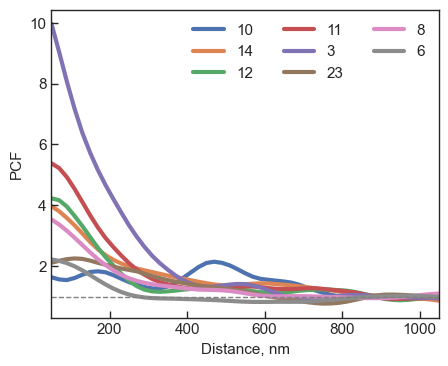


📊 Plot generated successfully:
   • Plotted 8 high-quality blobs (baseline CV ≤ 10%)
   • Saved as: dSTORM1_TX_nodiff_Malat_AF647_AF488-3-crossPCF.png
   • Distance range shown: 0-1000 nm

🔄 Cross-verification with original data:
   • Original high-quality blobs: 8
   • Loaded high-quality blobs: 8
   ✅ blob counts match perfectly!
   ✅ PCF data matches perfectly!


In [10]:
import pickle
import matplotlib.pyplot as plt

# Load the saved pickle file
prefix = ch1_file.split("cropped")[0]
fname_save = prefix + "blobs-pcf.p"

print(f"Loading saved PCF data from: {fname_save}")

try:
    with open(fname_save, "rb") as f:
        loaded_pcf_data = pickle.load(f)

    # Extract the data
    loaded_results = loaded_pcf_data["normalized_results"]
    bins = loaded_pcf_data["bin_centers"]  # This is what your code expects as 'bins'

    print(f"✅ Successfully loaded:")
    print(f"   • {len(loaded_results)} blobs")
    print(f"   • {len(bins)} distance bins")
    print(f"   • Distance range: {bins[0]:.0f}-{bins[-1]:.0f} nm")

    # Verify data integrity
    print(f"\n🔍 Data verification:")
    high_quality_blobs = sum(
        1 for result in loaded_results if result.get("baseline_cv", 1) <= 0.1
    )
    print(f"   • High quality blobs (CV ≤ 10%): {high_quality_blobs}")
    print(
        f"   • All blobs have normalized PCF: {all('pcf_normalized' in r for r in loaded_results)}"
    )

    # Use your plotting code with loaded data
    plt.figure(figsize=(5, 4))

    plotted_blobs = 0
    for result in loaded_results:  # Use loaded_results instead of normalized_results
        if result["baseline_cv"] > 0.1:
            continue
        plt.plot(bins, result["pcf_normalized"], lw=3, label=result["blob_name"])
        plotted_blobs += 1

    plt.axhline(1, ls="--", c="gray", lw=1)

    plt.legend(frameon=False, fontsize=11, ncols=3)
    plt.xlim(bins[0], bins[-1])
    # plt.ylim(0, 5)
    plt.xlabel("Distance, nm", fontsize=11)
    plt.ylabel("PCF", fontsize=11)
    plt.gca().spines[:].set_linewidth(1)
    plt.gca().tick_params(
        axis="both",
        which="major",
        labelsize=11,
        direction="in",
        bottom=True,
        left=True,
        length=5,
        width=1,
    )
    plt.gca().set_axisbelow(False)

    plt.savefig(prefix + "crossPCF.png", format="png", bbox_inches="tight", dpi=300)
    plt.show()

    print(f"\n📊 Plot generated successfully:")
    print(f"   • Plotted {plotted_blobs} high-quality blobs (baseline CV ≤ 10%)")
    print(f"   • Saved as: {prefix}crossPCF.png")
    print(f"   • Distance range shown: 0-1000 nm")

    # Additional verification - compare with original data if available
    if "normalized_results" in locals():
        print(f"\n🔄 Cross-verification with original data:")
        original_high_quality = sum(
            1 for result in normalized_results if result.get("baseline_cv", 1) <= 0.1
        )
        print(f"   • Original high-quality blobs: {original_high_quality}")
        print(f"   • Loaded high-quality blobs: {high_quality_blobs}")

        if original_high_quality == high_quality_blobs:
            print(f"   ✅ blob counts match perfectly!")

            # Check if first blob data matches
            if len(loaded_results) > 0 and len(normalized_results) > 0:
                orig_pcf = normalized_results[0]["pcf_normalized"]
                loaded_pcf = loaded_results[0]["pcf_normalized"]
                if np.allclose(orig_pcf, loaded_pcf):
                    print(f"   ✅ PCF data matches perfectly!")
                else:
                    print(f"   ⚠️  PCF data differs - check data integrity")
        else:
            print(f"   ⚠️  blob counts differ - investigate discrepancy")

except FileNotFoundError:
    print(f"❌ File not found: {fname_save}")
    print("   Make sure the pickle file was saved successfully first.")

except Exception as e:
    print(f"❌ Error loading or plotting: {e}")